In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tig.graph import TrafficIntelligenceGraph
from tig.update import TIGUpdater

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [3]:
# Graph 1: Traffic Intelligence Graph Topology
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 85, 15, 14.0, 35, "GREEN")
tig.add_junction("J2", 40, 35, 28.0, 20, "RED")
tig.add_junction("J3", 20, 50, 45.0, 5, "GREEN")
tig.add_junction("J4", 30, 40, 38.0, 12, "GREEN")
tig.add_junction("J5", 15, 55, 50.0, 3, "RED")

tig.add_influence("J1", "J2", weight=0.5, delay=120)
tig.add_influence("J1", "J3", weight=0.3, delay=90)
tig.add_influence("J2", "J4", weight=0.4, delay=100)
tig.add_influence("J3", "J4", weight=0.35, delay=80)
tig.add_influence("J4", "J5", weight=0.25, delay=60)

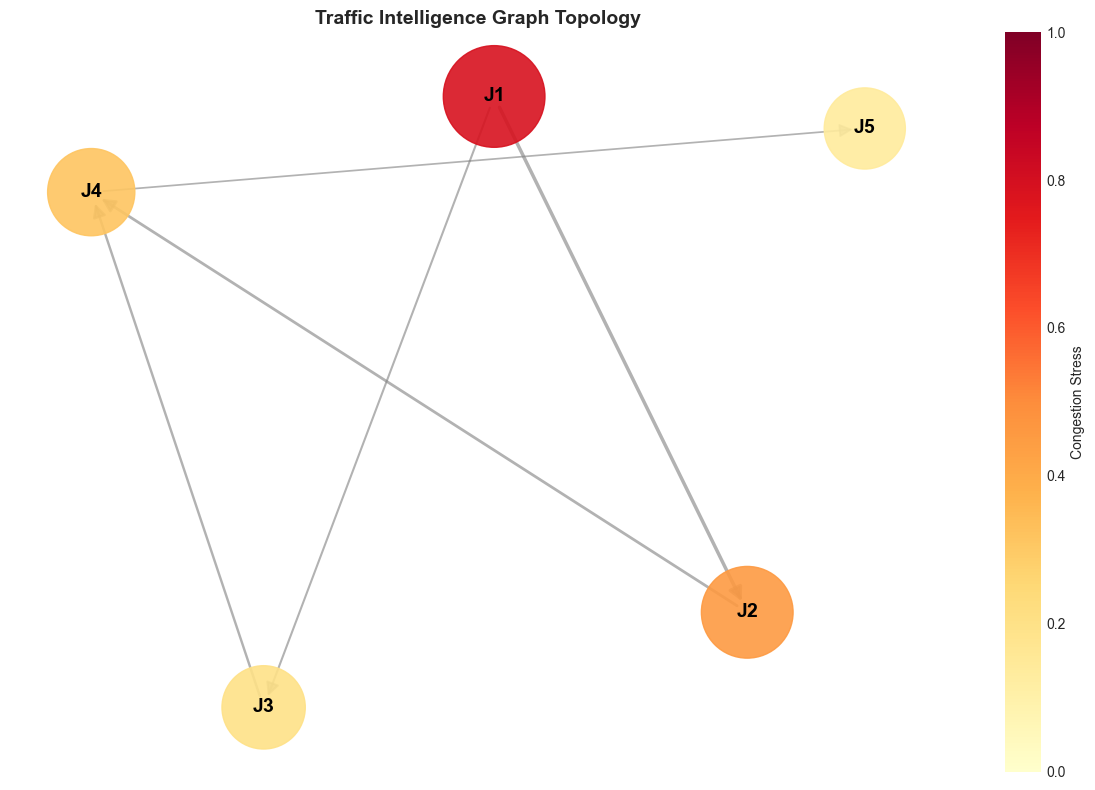

In [5]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(tig.graph, seed=42, k=2)

node_sizes = [3000 * (1 + updater.compute_junction_stress(tig.get_junction(n))) for n in tig.graph.nodes()]
node_colors = [updater.compute_junction_stress(tig.get_junction(n)) for n in tig.graph.nodes()]

nx.draw_networkx_nodes(tig.graph, pos, node_size=node_sizes, node_color=node_colors, 
                       cmap='YlOrRd', vmin=0, vmax=1, alpha=0.9)
nx.draw_networkx_edges(tig.graph, pos, width=[e[2]['weight']*5 for e in tig.graph.edges(data=True)], 
                       edge_color='gray', alpha=0.6, arrows=True, arrowsize=20)
nx.draw_networkx_labels(tig.graph, pos, font_size=14, font_weight='bold')

plt.title('Traffic Intelligence Graph Topology', fontsize=14, fontweight='bold')
plt.colorbar(plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(0, 1)), ax=plt.gca(), label='Congestion Stress')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Graph 2: Junction Congestion Score Over Time
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 90, 10, 12.0, 40, "GREEN")
tig.add_junction("J2", 30, 40, 35.0, 10, "RED")
tig.add_junction("J3", 20, 50, 45.0, 5, "GREEN")
tig.add_influence("J1", "J2", weight=0.5, delay=120)
tig.add_influence("J2", "J3", weight=0.4, delay=90)

time_steps = 15
history = {j: [] for j in tig.get_all_junctions()}

for step in range(time_steps):
    for j in tig.get_all_junctions():
        history[j].append(updater.compute_congestion_score(tig.get_junction(j)))
    updater.step(tig)

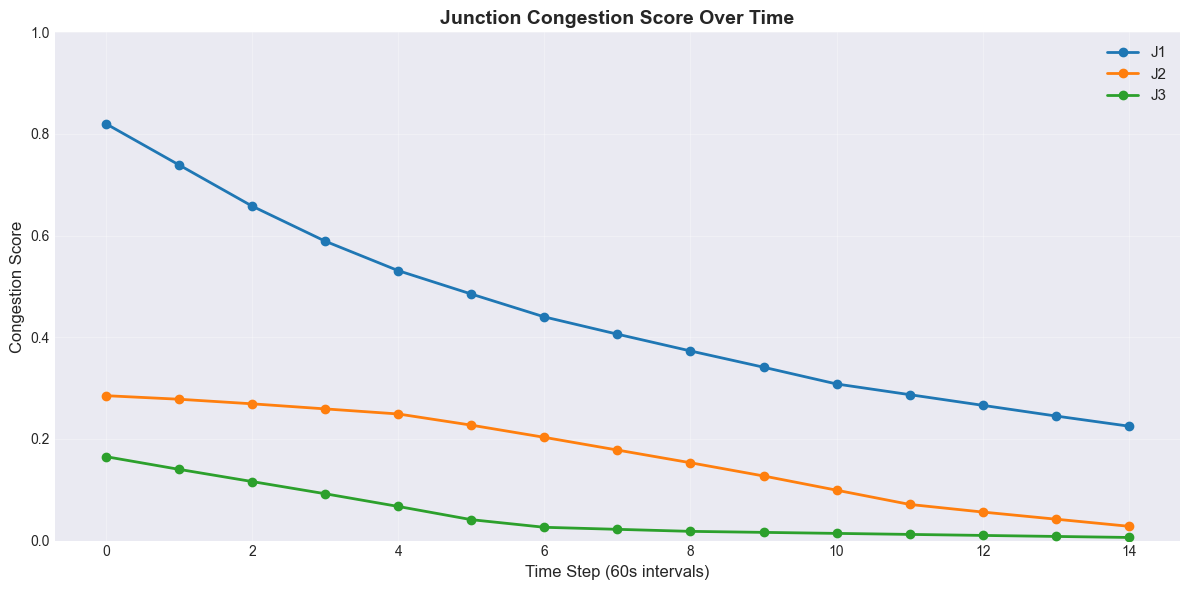

In [7]:
plt.figure(figsize=(12, 6))
for junction, scores in history.items():
    plt.plot(range(time_steps), scores, marker='o', linewidth=2, label=junction)

plt.xlabel('Time Step (60s intervals)', fontsize=12)
plt.ylabel('Congestion Score', fontsize=12)
plt.title('Junction Congestion Score Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [8]:
# Graph 3: Edge Weight Evolution
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 90, 10, 12.0, 40, "GREEN")
tig.add_junction("J2", 30, 40, 35.0, 10, "RED")
tig.add_junction("J3", 20, 50, 45.0, 5, "GREEN")
tig.add_influence("J1", "J2", weight=0.3, delay=120)
tig.add_influence("J2", "J3", weight=0.2, delay=90)

weight_history = {}
for step in range(15):
    for from_j, to_j, data in tig.graph.edges(data=True):
        edge = f"{from_j}→{to_j}"
        weight_history.setdefault(edge, []).append(data['weight'])
    updater.step(tig)

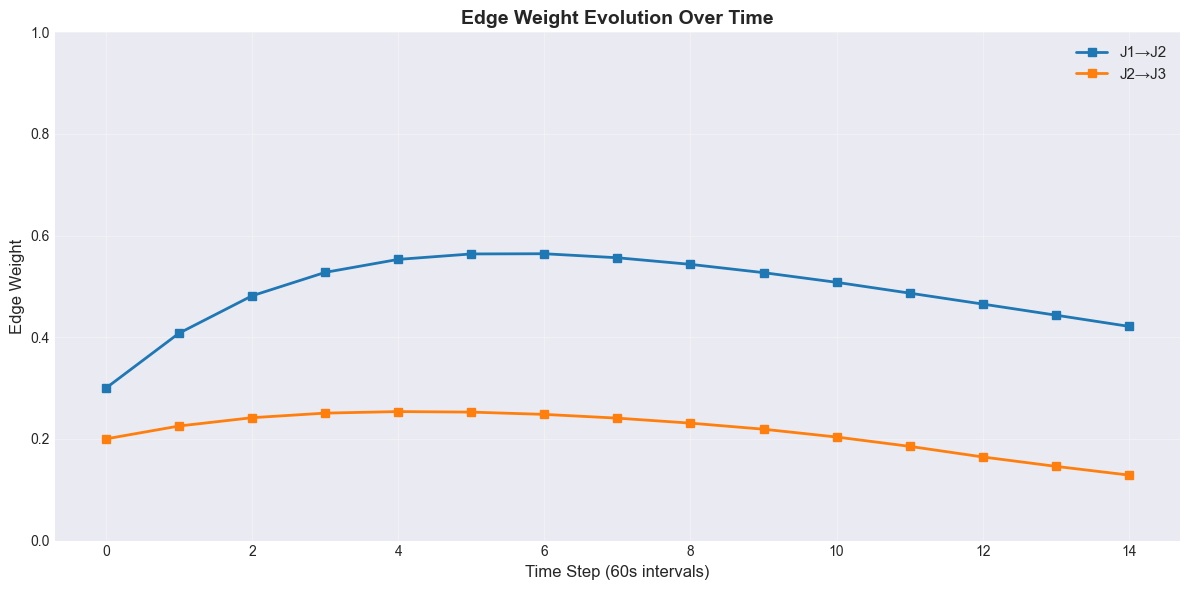

In [9]:
plt.figure(figsize=(12, 6))
for edge, weights in weight_history.items():
    plt.plot(range(15), weights, marker='s', linewidth=2, label=edge)

plt.xlabel('Time Step (60s intervals)', fontsize=12)
plt.ylabel('Edge Weight', fontsize=12)
plt.title('Edge Weight Evolution Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [10]:
# Graph 4: Congestion Propagation
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 90, 10, 12.0, 40, "GREEN")
tig.add_junction("J2", 30, 40, 35.0, 10, "RED")
tig.add_junction("J3", 20, 50, 45.0, 5, "GREEN")
tig.add_influence("J1", "J2", weight=0.5, delay=120)
tig.add_influence("J2", "J3", weight=0.4, delay=90)

vehicle_history = {j: [] for j in tig.get_all_junctions()}
for step in range(15):
    for j in tig.get_all_junctions():
        vehicle_history[j].append(tig.get_junction(j)['incoming_vehicle_count'])
    updater.step(tig)

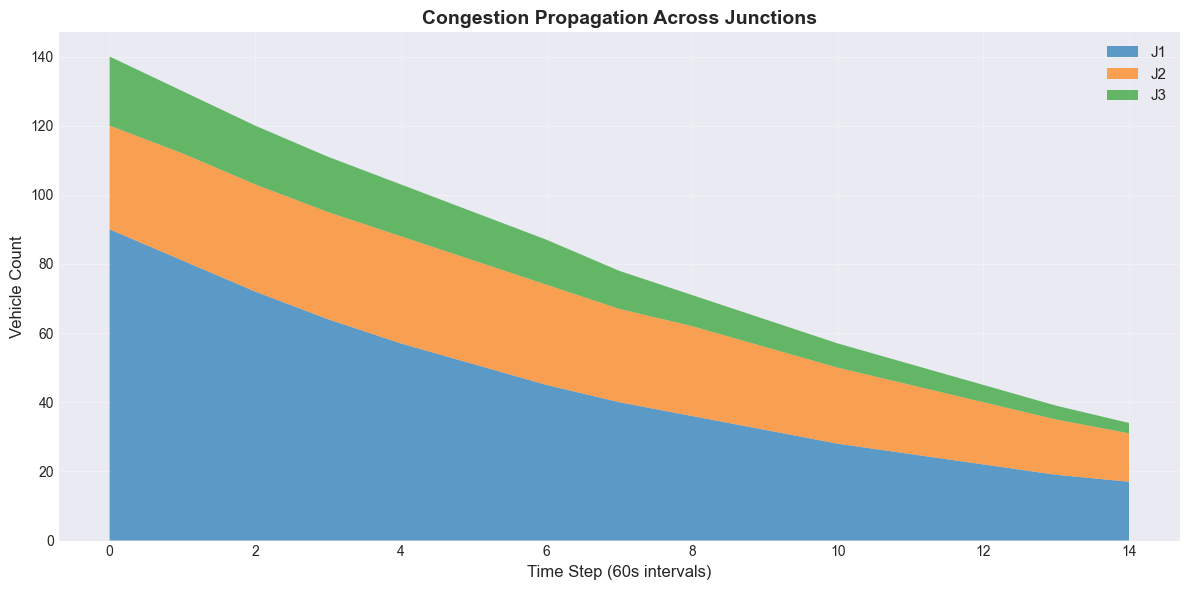

In [11]:
plt.figure(figsize=(12, 6))
data_matrix = np.array([vehicle_history[j] for j in vehicle_history.keys()])
plt.stackplot(range(15), data_matrix, labels=list(vehicle_history.keys()), alpha=0.7)

plt.xlabel('Time Step (60s intervals)', fontsize=12)
plt.ylabel('Vehicle Count', fontsize=12)
plt.title('Congestion Propagation Across Junctions', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Graph 5: Predicted vs Actual
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 90, 10, 12.0, 40, "GREEN")
tig.add_junction("J2", 30, 40, 35.0, 10, "RED")
tig.add_influence("J1", "J2", weight=0.5, delay=120)

j2_predicted, j2_actual = [], []
for step in range(15):
    j2_predicted.append(updater.predict_congestion(tig)['J2']['score'])
    updater.step(tig)
    j2_actual.append(updater.compute_congestion_score(tig.get_junction('J2')))

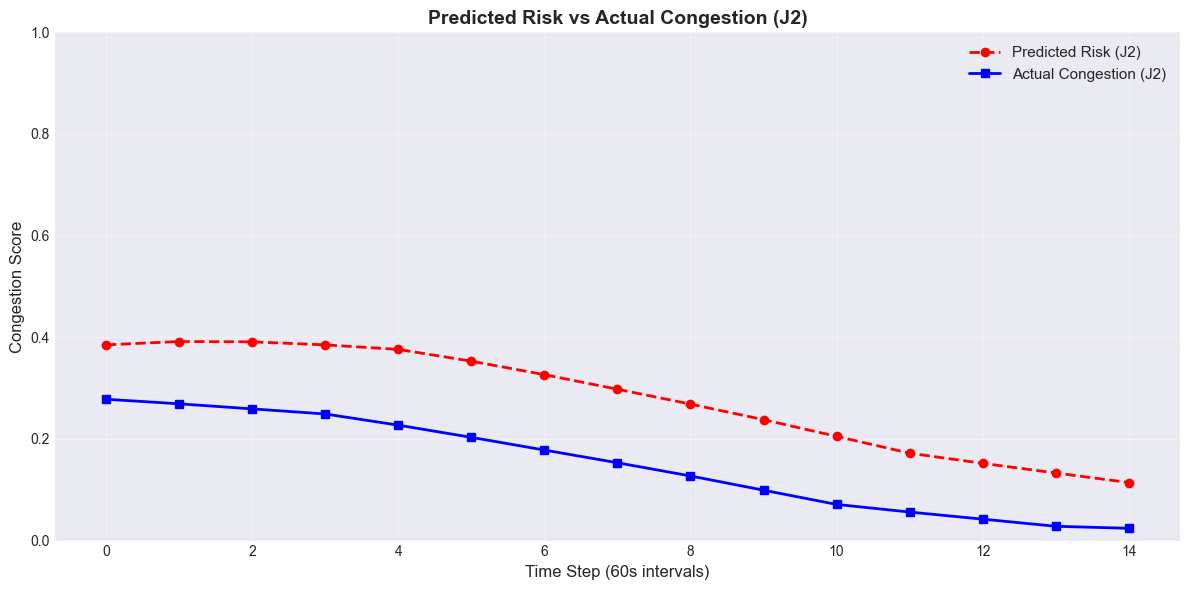

Prediction lead: 0.128


In [13]:
plt.figure(figsize=(12, 6))
plt.plot(range(15), j2_predicted, marker='o', linewidth=2, label='Predicted Risk (J2)', color='red', linestyle='--')
plt.plot(range(15), j2_actual, marker='s', linewidth=2, label='Actual Congestion (J2)', color='blue')

plt.xlabel('Time Step (60s intervals)', fontsize=12)
plt.ylabel('Congestion Score', fontsize=12)
plt.title('Predicted Risk vs Actual Congestion (J2)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"Prediction lead: {np.mean(np.array(j2_predicted) - np.array(j2_actual)):.3f}")

In [15]:
# Graph 6: Explainability Breakdown
tig = TrafficIntelligenceGraph()
updater = TIGUpdater()

tig.add_junction("J1", 85, 15, 14.0, 35, "GREEN")
tig.add_junction("J2", 40, 35, 28.0, 20, "RED")
tig.add_junction("J3", 20, 50, 45.0, 5, "GREEN")
tig.add_influence("J1", "J2", weight=0.5, delay=120)
tig.add_influence("J2", "J3", weight=0.4, delay=90)

for _ in range(3):
    updater.step(tig)

junctions, base_scores, influence_scores = [], [], []
for j_id in tig.get_all_junctions():
    junctions.append(j_id)
    base_scores.append(updater.compute_congestion_score(tig.get_junction(j_id)))
    influence_scores.append(sum(e[2]['weight'] * 0.2 for e in tig.graph.in_edges(j_id, data=True)))

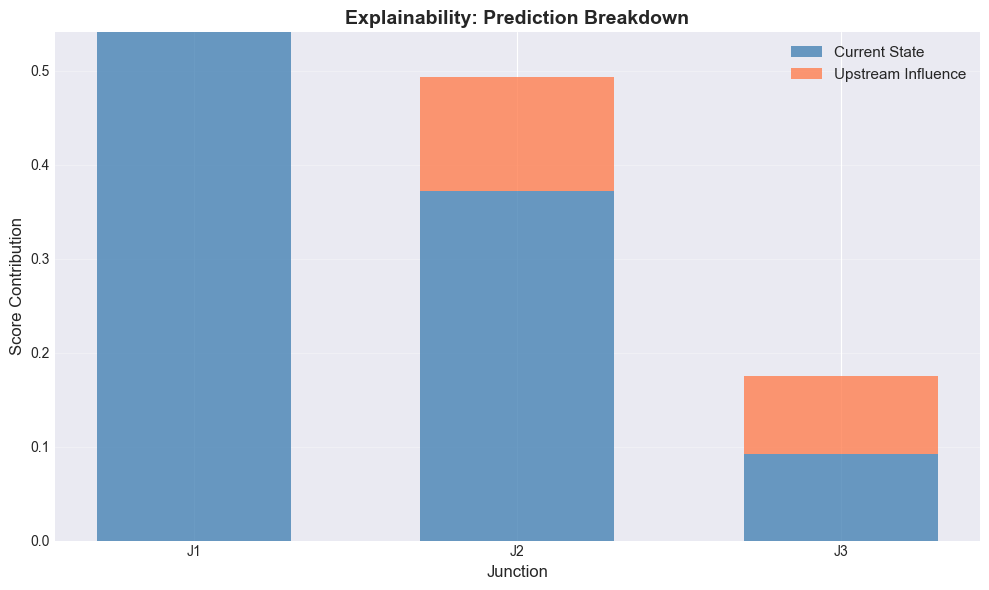

J1: MEDIUM - average speed is low
J2: MEDIUM - upstream junction congestion detected
J3: LOW - traffic conditions are stable


In [16]:
plt.figure(figsize=(10, 6))
x = np.arange(len(junctions))
plt.bar(x, base_scores, 0.6, label='Current State', color='steelblue', alpha=0.8)
plt.bar(x, influence_scores, 0.6, bottom=base_scores, label='Upstream Influence', color='coral', alpha=0.8)

plt.xlabel('Junction', fontsize=12)
plt.ylabel('Score Contribution', fontsize=12)
plt.title('Explainability: Prediction Breakdown', fontsize=14, fontweight='bold')
plt.xticks(x, junctions)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

predictions = updater.predict_congestion(tig)
for j, p in predictions.items():
    print(f"{j}: {p['risk']} - {', '.join(p['reason'])}")